# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [ ]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [ ]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

In [ ]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [6]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []

enumerate_kfold = list(enumerate(kfold))
for epoch in range(num_epochs):
    for k, (train, test) in enumerate_kfold:
        clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))
        score = clf.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 1.000
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 1.000
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.978
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 1.000
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 8, Class di

## Answer

Each fold should be run independently, thus the code should use fit() instead of partial_fit().

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

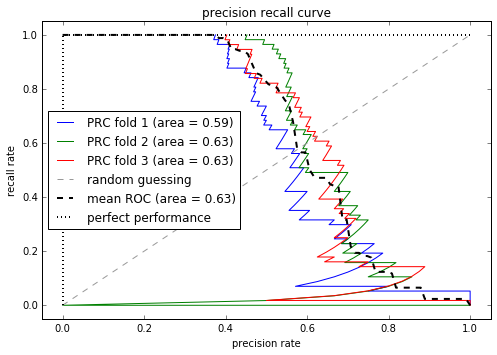

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
    from sklearn.cross_validation import KFold
else:
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

num_folds = 3

if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, n_folds=num_folds, random_state=1)
else:
    cv = list(StratifiedKFold(n_splits=num_folds, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_recall = 0.0
mean_precision = np.linspace(0, 1, 100)
all_recall = []

remove_last_dummy_element = False

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    precision, recall, thresholds = precision_recall_curve(y_train[test],
                                                           probas[:, 1],
                                                           pos_label=1)
    
    if remove_last_dummy_element:
        precision = precision[:-1]
        recall = recall[:-1]
   
    mean_recall += interp(mean_precision, precision, recall)
    
    prc_auc = auc(recall, precision)
    plt.plot(precision,
             recall,
             lw=1,
             label='PRC fold %d (area = %0.2f)'
                   % (i+1, prc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_recall /= len(cv)
mean_recall[0] = 1.0
mean_recall[-1] = 0.0
mean_auc = auc(mean_precision, mean_recall)
plt.plot(mean_precision, mean_recall, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('precision rate')
plt.ylabel('recall rate')
plt.title('precision recall curve')
plt.legend(loc="best")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()



Precision and recall rates tend to move in opposite directions, so the curves are decreasing.

ROC, in contrast, tends to be increasing.

PS: You guys are encouraged to write more on your plots and analysis.

# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [1]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [4]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [5]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


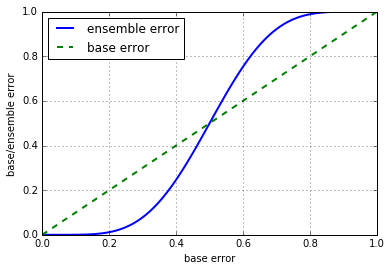

In [6]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [7]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):

    num_classifiers = range(1, max_num_classifier+1)
    ensemble_errors = [ensemble_error_func(num_classifier = num_classifier, base_error=base_error) for num_classifier in num_classifiers]

    plt.plot(num_classifiers, ensemble_errors, 
             label = 'ensemble error',
             linewidth = 2)
    plt.plot(range(max_num_classifier), [base_error]*max_num_classifier,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    
    plt.xlabel('num classifiers')
    plt.ylabel('ensemble error')
    plt.xlim([1, max_num_classifier])
    plt.ylim([0, 1])
    plt.title('base error %.2f' % base_error)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

As plotted below, increasing the number of classifiers may actually increase the error for ensemble_error().
In particular, when we have an even number of classifiers $n$, the ensemble error computed is larger than using a smaller odd-number of classifiers $n-1$.

In [8]:
max_num_classifiers = 20
base_error = 0.25

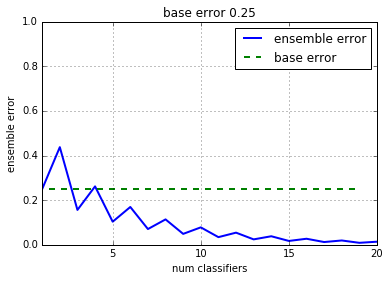

In [9]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

The reason is that the original method only applies when there is a clear majority, i.e. follow the vote made by more than half of classifiers.
It does not apply to tie breaker situation, i.e. $2k = n$, when there is no clear choice:
$$
\epsilon_{ensemble}
= 
\sum_{k=\left\lceil \frac{n}{2} \right\rceil}^n C\left(n, k\right) \epsilon^k \left(1-\epsilon\right)^{n-k}
$$

Thus, when $2k = n$, the error is over-estimated by the above equation.
For such tie-breaker situation, if we simply choose based on a coin flip (Bernoulli trial with uniform probability), the ensemble error should be:
$$
\epsilon_{ensemble}
= 
\sum_{k=\left\lceil \frac{n}{2} \right\rceil}^n 
\left(
C\left(n, k\right) \epsilon^k \left(1-\epsilon\right)^{n-k}
\times
\begin{cases}
0.5 \; if \; 2k = n \\
1 \; else
\end{cases}
\right)
$$

The improved code is as follows with a more reasonable plot of ensemble error versus number of classifiers.

#### More
Can you devise a better tie-breaker strategy that ensures the curve is monotonically decreasing (instead of just non-increasing)? But you need to give enough explantions and analysis to your proposed methods instead of just plotting the result.

In [10]:
def smooth_ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k))*(0.5 if 2*k == num_classifier else 1.0) for k in range(k_start, num_classifier+1)]
    return sum(probs)
    

In [14]:
# plot_base_error(smooth_ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

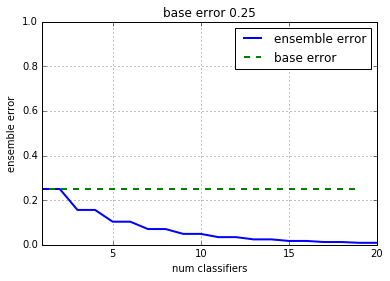

In [15]:
plot_num_classifier(smooth_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)